In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import random

import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

from pandas.tseries.offsets import BDay
from datetime import date
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
from scipy.stats import linregress
import itertools
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns


In [ ]:
data = pd.read_csv('filtered_data.csv')

In [ ]:
data

,Dates,A UN Equity PX_LAST,AAL UW Equity PX_LAST,AAPL UW Equity PX_LAST,ABBV UN Equity PX_LAST,ABNB UW Equity PX_LAST,ABT UN Equity PX_LAST,ACGL UW Equity PX_LAST,ACN UN Equity PX_LAST,ADBE UW Equity PX_LAST,...,WTW UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WY UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WYNN UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XEL UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XOM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XYL UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,YUM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBH UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBRA UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZTS UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg
0,2009-12-31,22.2178,NaN,7.531,NaN,NaN,25.8328,7.9500,41.50,36.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-04,22.3822,NaN,7.649,NaN,NaN,26.0576,7.9944,42.07,37.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-05,22.1391,NaN,7.656,NaN,NaN,25.8471,7.9678,42.33,37.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-06,22.0604,NaN,7.535,NaN,NaN,25.9907,7.9333,42.78,37.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-07,22.0318,NaN,7.521,NaN,NaN,26.2060,7.8867,42.74,36.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,2024-03-25,145.5600,14.92,170.850,178.53,167.99,110.0100,90.9900,333.82,507.23,...,-0.540976,105.699138,11.117085,88.970026,-2.110118,2.412094,7.310842,-21.768618,-446.148724,-0.475482
3581,2024-03-26,144.4100,14.92,169.710,179.19,167.39,111.5000,90.5900,336.39,507.60,...,-0.430159,96.751142,2.432251,90.696477,22.220362,2.545589,8.405890,-15.466415,-446.727737,1.671616
3582,2024-03-27,147.3700,15.30,173.310,180.35,166.41,113.4800,91.4800,340.94,504.40,...,-0.347305,102.674611,3.376781,88.217797,20.115445,3.078987,8.770739,-7.847573,-466.217533,7.521100
3583,2024-03-28,145.5100,15.35,171.480,182.10,164.96,113.6600,92.4400,346.61,504.60,...,-0.857699,109.476928,-1.568832,92.880852,26.606669,2.332288,14.234873,-8.444595,-465.628090,6.978706


In [ ]:
#Data Cleaning

In [ ]:
# Step 1: Convert the index to datetime format
data['Dates'] = pd.to_datetime(data['Dates'])
data.set_index('Dates', inplace=True)


In [ ]:
'''
#Step 2: Find the Rebalancing Dates
rebalancing_dates = []

for date in data.index:
    if date.month in [3, 6, 9, 12] and date.day == 1:
        if date.weekday() < 5:
            rebalancing_dates.append(date)
        else:
            next_business_day = date + BDay(1)
            rebalancing_dates.append(next_business_day)

rebalancing_dates = pd.Series(rebalancing_dates).drop_duplicates().sort_values()

rebalancing_dates
'''

0    2010-03-01
1    2010-06-01
2    2010-09-01
3    2010-12-01
4    2011-03-01
5    2011-06-01
6    2011-09-01
7    2011-12-01
8    2012-03-01
9    2012-06-01
10   2013-03-01
dtype: datetime64[ns]

In [ ]:
'''
#Step 3: Merging the variables based on the rebalancing dates
rebalancing_data = data.loc[rebalancing_dates]

# Ensure that the original columns are preserved
original_columns = rebalancing_data.columns.tolist()

rebalancing_data
'''

,A UN Equity PX_LAST,AAL UW Equity PX_LAST,AAPL UW Equity PX_LAST,ABBV UN Equity PX_LAST,ABNB UW Equity PX_LAST,ABT UN Equity PX_LAST,ACGL UW Equity PX_LAST,ACN UN Equity PX_LAST,ADBE UW Equity PX_LAST,ADI UW Equity PX_LAST,...,WTW UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WY UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WYNN UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XEL UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XOM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XYL UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,YUM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBH UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBRA UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZTS UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg
Dates,,,,,,,,,,,,,,,,,,,,,
2010-03-01,22.9471,NaN,7.464,NaN,NaN,25.9763,8.3333,40.09,34.890,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-01,22.5109,NaN,9.315,NaN,NaN,22.4595,8.0011,36.71,32.130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,20.2298,NaN,8.940,NaN,NaN,24.0528,9.0733,37.40,28.855,NaN,...,NaN,-62.621883,1.782380,NaN,0.149670,NaN,2.943656,4.274694,-15.186615,NaN
2010-12-01,25.8289,NaN,11.300,NaN,NaN,22.4930,10.0778,44.00,28.370,NaN,...,NaN,33.210086,4.163120,NaN,10.628930,NaN,3.191651,-0.944478,3.753884,NaN
2011-03-01,29.0897,NaN,12.483,NaN,NaN,22.7275,10.0122,51.16,33.970,NaN,...,NaN,2.674630,1.025991,NaN,1.087244,NaN,0.593091,-0.137236,-1.434704,NaN
2011-06-01,34.3242,NaN,12.339,NaN,NaN,24.8423,11.1533,56.98,34.120,NaN,...,NaN,-1.239415,1.014568,NaN,-0.586593,NaN,6.796269,2.893562,6.095913,NaN
2011-09-01,25.6287,NaN,13.612,NaN,NaN,24.8519,11.3133,52.90,24.770,NaN,...,NaN,12.475094,6.429339,NaN,5.117335,NaN,-61.370056,8.781405,-3.008747,NaN
2011-12-01,27.0446,NaN,13.855,NaN,NaN,26.0863,12.4933,57.97,27.140,NaN,...,NaN,-0.513024,4.258636,NaN,10.219966,NaN,-148.553621,2.152742,2.618506,NaN
2012-03-01,31.5782,NaN,19.445,NaN,NaN,27.4261,12.5300,59.68,33.100,NaN,...,NaN,4.026084,1.474534,NaN,9.138547,NaN,2.711951,10.114195,19.910663,NaN


In [ ]:
rebalancing_data = data

In [ ]:
# Drop columns containing "PX_LAST 6_Month_Momentum Daily Change"
columns_to_drop = [col for col in rebalancing_data.columns if "PX_LAST 6_Month_Momentum Daily Change" in col and "30_day_MovAvg" not in col]
rebalancing_data.drop(columns=columns_to_drop, inplace=True)

rebalancing_data

,A UN Equity PX_LAST,AAL UW Equity PX_LAST,AAPL UW Equity PX_LAST,ABBV UN Equity PX_LAST,ABNB UW Equity PX_LAST,ABT UN Equity PX_LAST,ACGL UW Equity PX_LAST,ACN UN Equity PX_LAST,ADBE UW Equity PX_LAST,ADI UW Equity PX_LAST,...,WTW UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WY UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,WYNN UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XEL UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XOM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,XYL UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,YUM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBH UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZBRA UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg,ZTS UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg
Dates,,,,,,,,,,,,,,,,,,,,,
2009-12-31,22.2178,NaN,7.531,NaN,NaN,25.8328,7.9500,41.50,36.78,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,22.3822,NaN,7.649,NaN,NaN,26.0576,7.9944,42.07,37.09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,22.1391,NaN,7.656,NaN,NaN,25.8471,7.9678,42.33,37.70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,22.0604,NaN,7.535,NaN,NaN,25.9907,7.9333,42.78,37.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,22.0318,NaN,7.521,NaN,NaN,26.2060,7.8867,42.74,36.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,145.5600,14.92,170.850,178.53,167.99,110.0100,90.9900,333.82,507.23,190.63,...,-0.540976,105.699138,11.117085,88.970026,-2.110118,2.412094,7.310842,-21.768618,-446.148724,-0.475482
2024-03-26,144.4100,14.92,169.710,179.19,167.39,111.5000,90.5900,336.39,507.60,188.96,...,-0.430159,96.751142,2.432251,90.696477,22.220362,2.545589,8.405890,-15.466415,-446.727737,1.671616
2024-03-27,147.3700,15.30,173.310,180.35,166.41,113.4800,91.4800,340.94,504.40,193.33,...,-0.347305,102.674611,3.376781,88.217797,20.115445,3.078987,8.770739,-7.847573,-466.217533,7.521100


In [ ]:
#Step 4: Filter columns containing PX_LAST and calculate their percentage Change
price_columns = [col for col in rebalancing_data.columns if "PX_LAST" in col and "Momentum" not in col]

# Initialize a new DataFrame to store the percentage changes
percentage_changes = pd.DataFrame(index=rebalancing_data.index)

# Loop through each filtered column to calculate the percentage change
for column in price_columns:
    percentage_changes[column] = rebalancing_data[column].pct_change().shift(-1)

# Remove the last row because it has no following period to compare
percentage_changes = percentage_changes[:-1]

percentage_changes

,A UN Equity PX_LAST,AAL UW Equity PX_LAST,AAPL UW Equity PX_LAST,ABBV UN Equity PX_LAST,ABNB UW Equity PX_LAST,ABT UN Equity PX_LAST,ACGL UW Equity PX_LAST,ACN UN Equity PX_LAST,ADBE UW Equity PX_LAST,ADI UW Equity PX_LAST,...,WTW UW Equity PX_LAST,WY UN Equity PX_LAST,WYNN UW Equity PX_LAST,XEL UW Equity PX_LAST,XOM UN Equity PX_LAST,XYL UN Equity PX_LAST,YUM UN Equity PX_LAST,ZBH UN Equity PX_LAST,ZBRA UW Equity PX_LAST,ZTS UN Equity PX_LAST
Dates,,,,,,,,,,,,,,,,,,,,,
2009-12-31,0.007399,NaN,0.015669,NaN,NaN,0.008702,0.005585,0.013735,0.008428,NaN,...,NaN,0.026422,0.098403,NaN,0.014078,NaN,0.003432,0.015395,0.010931,NaN
2010-01-04,-0.010861,NaN,0.000915,NaN,NaN,-0.008078,-0.003327,0.006180,0.016446,NaN,...,NaN,0.021228,0.060819,NaN,0.003905,NaN,-0.003420,0.031656,-0.001744,NaN
2010-01-05,-0.003555,NaN,-0.015805,NaN,NaN,0.005556,-0.004330,0.010631,-0.002122,NaN,...,NaN,-0.011055,-0.013117,NaN,0.008643,NaN,-0.007146,-0.000323,-0.007687,NaN
2010-01-06,-0.001296,NaN,-0.001858,NaN,NaN,0.008284,-0.005874,-0.000935,-0.019405,NaN,...,NaN,-0.004469,0.021356,NaN,-0.003142,NaN,-0.000288,0.022941,-0.025000,NaN
2010-01-07,-0.000322,NaN,0.006648,NaN,NaN,0.005110,-0.001978,-0.003978,-0.005422,NaN,...,NaN,-0.009209,-0.007165,NaN,-0.004011,NaN,0.000288,-0.021005,-0.003250,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,-0.012818,0.006748,-0.008300,0.000448,0.000774,-0.005065,0.003419,-0.010904,0.015435,-0.014883,...,0.001867,-0.003370,-0.004805,0.004018,0.010221,-0.011222,-0.011818,0.005582,0.022303,-0.006454
2024-03-25,-0.007901,0.000000,-0.006673,0.003697,-0.003572,0.013544,-0.004396,0.007699,0.000729,-0.008760,...,0.001534,-0.001127,0.011769,-0.012957,-0.007501,0.001096,0.001337,-0.000313,-0.022018,-0.012753
2024-03-26,0.020497,0.025469,0.021213,0.006474,-0.005855,0.017758,0.009824,0.013526,-0.006304,0.023127,...,0.006493,0.013540,0.012030,0.030502,0.010370,0.011572,0.018694,0.037069,0.026701,0.017143


In [ ]:
#Step 5: Changing the column names
for col in percentage_changes.columns:
  percentage_changes.columns = [col.replace("PX_LAST", "Forward_Change") for col in percentage_changes.columns]

# Step 6: Add a binary variable for the top 10% greatest forward changes
binary_df = pd.DataFrame(index=percentage_changes.index)

for column in percentage_changes.columns:
    threshold = percentage_changes[column].quantile(0.9)
    binary_df[column + '_Top10'] = (percentage_changes[column] >= threshold).astype(int)

# Combine percentage_changes and binary_df
final_df = pd.concat([percentage_changes, binary_df], axis=1)

final_df
final_df.columns

Index(['A UN Equity Forward_Change', 'AAL UW Equity Forward_Change',
       'AAPL UW Equity Forward_Change', 'ABBV UN Equity Forward_Change',
       'ABNB UW Equity Forward_Change', 'ABT UN Equity Forward_Change',
       'ACGL UW Equity Forward_Change', 'ACN UN Equity Forward_Change',
       'ADBE UW Equity Forward_Change', 'ADI UW Equity Forward_Change',
       ...
       'WTW UW Equity Forward_Change_Top10',
       'WY UN Equity Forward_Change_Top10',
       'WYNN UW Equity Forward_Change_Top10',
       'XEL UW Equity Forward_Change_Top10',
       'XOM UN Equity Forward_Change_Top10',
       'XYL UN Equity Forward_Change_Top10',
       'YUM UN Equity Forward_Change_Top10',
       'ZBH UN Equity Forward_Change_Top10',
       'ZBRA UW Equity Forward_Change_Top10',
       'ZTS UN Equity Forward_Change_Top10'],
      dtype='object', length=1006)

In [ ]:
#Extract Stock Names
stock_names = [col.replace("Forward_Change", "").strip() for col in percentage_changes.columns]
stock_names

['A UN Equity',
 'AAL UW Equity',
 'AAPL UW Equity',
 'ABBV UN Equity',
 'ABNB UW Equity',
 'ABT UN Equity',
 'ACGL UW Equity',
 'ACN UN Equity',
 'ADBE UW Equity',
 'ADI UW Equity',
 'ADM UN Equity',
 'ADP UW Equity',
 'ADSK UW Equity',
 'AEE UN Equity',
 'AEP UW Equity',
 'AES UN Equity',
 'AFL UN Equity',
 'AIG UN Equity',
 'AIZ UN Equity',
 'AJG UN Equity',
 'AKAM UW Equity',
 'ALB UN Equity',
 'ALGN UW Equity',
 'ALL UN Equity',
 'ALLE UN Equity',
 'AMAT UW Equity',
 'AMCR UN Equity',
 'AMD UW Equity',
 'AME UN Equity',
 'AMGN UW Equity',
 'AMP UN Equity',
 'AMT UN Equity',
 'AMZN UW Equity',
 'ANET UN Equity',
 'ANSS UW Equity',
 'AON UN Equity',
 'AOS UN Equity',
 'APA UW Equity',
 'APD UN Equity',
 'APH UN Equity',
 'APTV UN Equity',
 'ARE UN Equity',
 'ATO UN Equity',
 'AVB UN Equity',
 'AVGO UW Equity',
 'AVY UN Equity',
 'AWK UN Equity',
 'AXON UW Equity',
 'AXP UN Equity',
 'AZO UN Equity',
 'BA UN Equity',
 'BAC UN Equity',
 'BALL UN Equity',
 'BAX UN Equity',
 'BBWI UN Eq

In [ ]:
# Print the column names in rebalancing_data to verify
print("Columns in rebalancing_data:")
print(rebalancing_data.columns)

Columns in rebalancing_data:
Index(['A UN Equity PX_LAST', 'AAL UW Equity PX_LAST',
       'AAPL UW Equity PX_LAST', 'ABBV UN Equity PX_LAST',
       'ABNB UW Equity PX_LAST', 'ABT UN Equity PX_LAST',
       'ACGL UW Equity PX_LAST', 'ACN UN Equity PX_LAST',
       'ADBE UW Equity PX_LAST', 'ADI UW Equity PX_LAST',
       ...
       'WTW UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'WY UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'WYNN UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'XEL UW Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'XOM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'XYL UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'YUM UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'ZBH UN Equity PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg',
       'ZBRA UW Equity PX_LAST 6_Month_Momentum Daily Change 30_

In [ ]:
# Convert final_df and rebalancing_data indices to datetime
final_df.index = pd.to_datetime(final_df.index)
rebalancing_data.index = pd.to_datetime(rebalancing_data.index)

# Create lists to hold the merged and aggregated data
merged_data = []
aggregated_data = []

In [ ]:
# Iterate over the stock names
for stock in stock_names:
    # Define the required column names for the current stock
    momentum_avg_col = f"{stock} PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg"
    forward_change_col = f"{stock} Forward_Change_Top10"
    momentum_col = f"{stock} PX_LAST 6_Month_Momentum"

    # Check if all required columns are present
    if (momentum_avg_col in rebalancing_data.columns and
        forward_change_col in final_df.columns and
        momentum_col in rebalancing_data.columns):

        # Subset the data for the current stock
        forward_subset = final_df[[forward_change_col]]
        momentum_subset = rebalancing_data[[momentum_avg_col, momentum_col]]

        # Merging the data for the current stock using the index (dates)
        stock_merged = pd.merge(forward_subset, momentum_subset, left_index=True, right_index=True, how='inner')

        # Removing rows with any NaN values
        stock_merged.dropna(inplace=True)

        # Aggregating the data into a new structure with stock identifier and dates
        for date, row in stock_merged.iterrows():
            aggregated_row = [stock, date] + list(row.values)
            aggregated_data.append(aggregated_row)

# Print the first few rows of aggregated_data to debug
print("Sample of aggregated_data:", aggregated_data[:5])

# Creating the final aggregated DataFrame with stock identifiers and dates
column_names = ['Stock', 'Date', 'Top_10', 'Momentum_6M_30D_MA', 'Momentum_6M_M']
aggregated_df = pd.DataFrame(aggregated_data, columns=column_names)

# Set the 'Date' column as the index
aggregated_df.set_index('Date', inplace=True)

# Sort by date to ensure all stock data for a day is together
aggregated_df.sort_index(inplace=True)

# Display the final DataFrame
print(aggregated_df)

Sample of aggregated_data: [['A UN Equity', Timestamp('2010-08-16 00:00:00'), 1.0, -75.96984229850632, -10.214780365579657], ['A UN Equity', Timestamp('2010-08-17 00:00:00'), 0.0, -78.11265490419623, -4.407595271902142], ['A UN Equity', Timestamp('2010-08-18 00:00:00'), 0.0, -76.58430508025259, -4.970794550723601], ['A UN Equity', Timestamp('2010-08-19 00:00:00'), 0.0, -73.77094772099464, -8.525505699059199], ['A UN Equity', Timestamp('2010-08-20 00:00:00'), 0.0, -74.05424368862558, -8.314702581369248]]
                     Stock  Top_10  Momentum_6M_30D_MA  Momentum_6M_M
Date                                                                 
2010-08-16     A UN Equity     1.0          -75.969842     -10.214780
2010-08-16    CF UN Equity     1.0            0.559348     -18.325770
2010-08-16  CTRA UN Equity     0.0            0.139051     -26.083762
2010-08-16     D UN Equity     1.0           29.565151      15.141213
2010-08-16  AMGN UW Equity     0.0            4.398063      -5.106159
.

Confusion Matrix on the Test Set:
[[351006      0]
 [ 46068      0]]


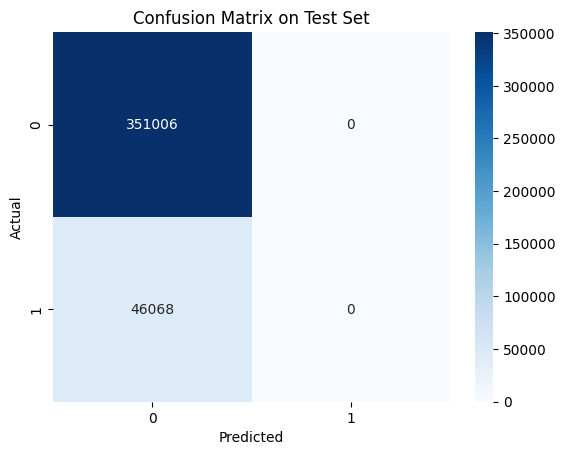

In [ ]:
#Time Series Pass 1:

# Prepare the data
aggregated_df = aggregated_df.drop(columns=['Stock'])  # Drop the Stock column
aggregated_df = aggregated_df.dropna()  # Drop rows with missing values

# Ensure 'Top_10' is binary (if not already)
aggregated_df['Top_10'] = aggregated_df['Top_10'].apply(lambda x: 1 if x > 0 else 0)

# Split the data into train and test sets based on time periods
train_data = aggregated_df[aggregated_df.index < '2021-01-01']
test_data = aggregated_df[aggregated_df.index >= '2021-01-01']

# Separate predictors and target variable
X_train = train_data.drop(columns=['Top_10'])
y_train = train_data['Top_10']
X_test = test_data.drop(columns=['Top_10'])
y_test = test_data['Top_10']

# Define the logistic regression model
model = LogisticRegression()

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train the model with k-fold cross-validation
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    val_predictions = model.predict(X_val_fold)

    # You can print the confusion matrix for each fold if needed
    # cm = confusion_matrix(y_val_fold, val_predictions)
    # print(f"Confusion Matrix for Fold:\n{cm}")

# Train the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Confusion matrix on the test set
cm = confusion_matrix(y_test, test_predictions)
print(f"Confusion Matrix on the Test Set:\n{cm}")

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
# Convert final_df and rebalancing_data indices to datetime
final_df.index = pd.to_datetime(final_df.index)
rebalancing_data.index = pd.to_datetime(rebalancing_data.index)

# Create lists to hold the merged and aggregated data
merged_data = []
aggregated_data = []

In [ ]:
# Iterate over the stock names
for stock in stock_names:
    # Define the required column names for the current stock
    momentum_avg_col = f"{stock} PX_LAST 6_Month_Momentum Daily Change 30_day_MovAvg"
    forward_change_col = f"{stock} Forward_Change_Top10"
    momentum_col = f"{stock} PX_LAST 6_Month_Momentum"

    # Check if all required columns are present
    if (momentum_avg_col in rebalancing_data.columns and
        forward_change_col in final_df.columns and
        momentum_col in rebalancing_data.columns):

        # Subset the data for the current stock
        forward_subset = final_df[[forward_change_col]]
        momentum_subset = rebalancing_data[[momentum_avg_col, momentum_col]]

        # Merging the data for the current stock using the index (dates)
        stock_merged = pd.merge(forward_subset, momentum_subset, left_index=True, right_index=True, how='inner')

        # Removing rows with any NaN values
        stock_merged.dropna(inplace=True)

        # Aggregating the data into a new structure with stock identifier and dates
        for date, row in stock_merged.iterrows():
            aggregated_row = [stock, date] + list(row.values)
            aggregated_data.append(aggregated_row)

# Print the first few rows of aggregated_data to debug
print("Sample of aggregated_data:", aggregated_data[:5])

# Creating the final aggregated DataFrame with stock identifiers and dates
column_names = ['Stock', 'Date', 'Top_10', 'Momentum_6M_30D_MA', 'Momentum_6M_M']
aggregated_df = pd.DataFrame(aggregated_data, columns=column_names)

# Set the 'Date' column as the index
aggregated_df.set_index('Date', inplace=True)

# Sort by date to ensure all stock data for a day is together
aggregated_df.sort_index(inplace=True)

# Display the final DataFrame
print(aggregated_df)

In [ ]:
#Time Series Pass 2:
# Prepare the data
aggregated_df = aggregated_df.drop(columns=['Stock'])  # Drop the Stock column
aggregated_df = aggregated_df.dropna()  # Drop rows with missing values

# Ensure 'Top_10' is binary (if not already)
aggregated_df['Top_10'] = aggregated_df['Top_10'].apply(lambda x: 1 if x > 0 else 0)

# Split the data into train and test sets based on time periods
train_data = aggregated_df[aggregated_df.index < '2021-01-01']
test_data = aggregated_df[aggregated_df.index >= '2021-01-01']

# Separate predictors and target variable
X_train = train_data.drop(columns=['Top_10'])
y_train = train_data['Top_10']
X_test = test_data.drop(columns=['Top_10'])
y_test = test_data['Top_10']

# Define the logistic regression model with class weights
model = LogisticRegression(class_weight={0: 1, 1: 9})

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train the model with k-fold cross-validation
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    val_predictions = model.predict(X_val_fold)

    # You can print the confusion matrix for each fold if needed
    # cm = confusion_matrix(y_val_fold, val_predictions)
    # print(f"Confusion Matrix for Fold:\n{cm}")

# Train the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Confusion matrix on the test set
cm = confusion_matrix(y_test, test_predictions)
print(f"Confusion Matrix on the Test Set:\n{cm}")

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

print("Beta Coefficients:", beta_coefficients)
print("Intercept:", intercept)

KeyError: "['Stock'] not found in axis"

In [ ]:
#Pass 1 & 2:
'''
# Define the predictors and target
X = aggregated_df[['Momentum_6M_30D_MA', 'Momentum_6M_M']]
y = aggregated_df['Top_10']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model with adjusted class weights
class_weights = {0: 1, 1: 3}  # Adjust these weights as needed to penalize false negatives more
logistic_model = LogisticRegression(class_weight=class_weights)  #Balanced weights equate to porportional penalty for the porportion of your dataset

# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the coefficients and intercept
print("Coefficients:", logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)
'''

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      3090
         1.0       0.00      0.00      0.00       424

    accuracy                           0.88      3514
   macro avg       0.44      0.50      0.47      3514
weighted avg       0.77      0.88      0.82      3514

Confusion Matrix:
[[3090    0]
 [ 424    0]]
Coefficients: [[-0.00039961 -0.00422747]]
Intercept: [-1.94246754]


In [ ]:
#Model Tuning Parameter - Pass 3
'''
def evaluate_class_weights(X, y, start=0.1, stop=2.0, step=0.1):
    # Initialize lists to store results
    accuracies = []
    weight_0_values = []
    weight_1_values = []

    # Generate the range of class weights
    weight_range = list(range(int(start * 10), int(stop * 10), int(step * 10)))

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Iterate over the weight values
    for w0 in weight_range:
        for w1 in weight_range:
            class_weights = {0: w0 / 10.0, 1: w1 / 10.0}
            logistic_model = LogisticRegression(class_weight=class_weights, max_iter=1000)

            # Fit the model
            logistic_model.fit(X_train, y_train)

            # Make predictions
            y_pred = logistic_model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Store the results
            accuracies.append(accuracy)
            weight_0_values.append(class_weights[0])
            weight_1_values.append(class_weights[1])

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'class_weight_0': weight_0_values,
        'class_weight_1': weight_1_values,
        'accuracy': accuracies
    })

    return results_df

# Assuming `aggregated_df` has already been created as per the previous steps

# Define the predictors and target
X = aggregated_df[['Momentum_6M_30D_MA', 'Momentum_6M_M']]
y = aggregated_df['Top_10']

# Run the evaluation function
results_df = evaluate_class_weights(X, y)

# Display the results
print(results_df)

# Find the best combination of class weights
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print("Best class weights and accuracy:")
print(best_result)

#Save Results to CSV
results_df.to_csv('class_weight_evaluation_results.csv', index=False)
'''

In [ ]:
#Pass 4 - Synthetic Oversampling of TOP_10 1 Values to balance Data set
'''
# Define the predictors and target
X = aggregated_df[['Momentum_6M_30D_MA', 'Momentum_6M_M']]
y = aggregated_df['Top_10']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize a standard logistic regression model without class weights
logistic_model = LogisticRegression(max_iter=1000)

# Fit the model on the resampled training data
logistic_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = logistic_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the coefficients and intercept
print("Coefficients:", logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'accuracy': [accuracy],
    'coefficients': [logistic_model.coef_.flatten().tolist()],
    'intercept': logistic_model.intercept_.tolist()
})
'''

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.51      0.65      3084
         1.0       0.13      0.55      0.22       430

    accuracy                           0.51      3514
   macro avg       0.51      0.53      0.43      3514
weighted avg       0.80      0.51      0.59      3514

Confusion Matrix:
[[1563 1521]
 [ 194  236]]
Coefficients: [[-0.00035    -0.00412635]]
Intercept: [0.02301078]


In [ ]:
#Pass 5 - Grid Search Hyper Parameter Tuning and K neighbor Tuning

'''
# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(max_iter=1000))
])

# Define the parameter grid
param_grid = {
    'smote__k_neighbors': [3, 5, 7, 10],
    'logistic__C': [0.1, 1.0, 10.0, 100.0],  # Regularization parameter
    'logistic__solver': ['liblinear', 'saga']  # Different solvers
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the coefficients and intercept
print("Coefficients:", best_model.named_steps['logistic'].coef_)
print("Intercept:", best_model.named_steps['logistic'].intercept_)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'accuracy': [accuracy],
    'coefficients': [best_model.named_steps['logistic'].coef_.flatten().tolist()],
    'intercept': best_model.named_steps['logistic'].intercept_.tolist()
})
'''

Best parameters: {'logistic__C': 10.0, 'logistic__solver': 'saga', 'smote__k_neighbors': 7}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.61      0.73      3084
         1.0       0.14      0.46      0.22       430

    accuracy                           0.59      3514
   macro avg       0.52      0.54      0.47      3514
weighted avg       0.80      0.59      0.66      3514

Confusion Matrix:
[[1890 1194]
 [ 231  199]]
Coefficients: [[-0.00031307 -0.00406599]]
Intercept: [0.00040753]


In [ ]:
# Pass 6 - Gradient Boosted Classifier Model, SMOTE & Grid Search

'''
# Define the predictors and target
X = aggregated_df[['Momentum_6M_30D_MA', 'Momentum_6M_M', 'Top_10']]

# Drop rows with any NaN values
X = X.dropna()

# Separate the features and target after removing NaNs
y = X['Top_10']
X = X.drop('Top_10', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors= 10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the preprocessing and model pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_leaf_nodes': [31, 50, 100],
    'classifier__min_samples_leaf': [15, 50, 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'accuracy': [accuracy],
    'best_params': [best_params]
})
'''

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_iter': 300, 'classifier__max_leaf_nodes': 100, 'classifier__min_samples_leaf': 20}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77      3084
         1.0       0.12      0.32      0.18       430

    accuracy                           0.64      3514
   macro avg       0.50      0.50      0.47      3514
weighted avg       0.79      0.64      0.70      3514

Confusion Matrix:
[[2102  982]
 [ 292  138]]


In [ ]:
# Pass 7 - Gradient Boosted Classifier Model, SMOTE & Grid Search, LN Transformations, & X Interaction Term

'''
# Define the predictors and target
X = aggregated_df[['Momentum_6M_30D_MA', 'Momentum_6M_M', 'Top_10']]

# Feature engineering: log transformation
X['Log_Momentum_6M_30D_MA'] = np.log1p(X['Momentum_6M_30D_MA'])
X['Log_Momentum_6M_M'] = np.log1p(X['Momentum_6M_M'])

# Feature engineering: interaction term
X['Interaction'] = X['Momentum_6M_30D_MA'] * X['Momentum_6M_M']

# Drop rows with any NaN values
X = X.dropna()

# Separate the features and target after removing NaNs
y = X['Top_10']
X = X.drop('Top_10', axis=1)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors= 4)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the preprocessing and model pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_leaf_nodes': [31, 50, 100],
    'classifier__min_samples_leaf': [15, 50, 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'accuracy': [accuracy],
    'best_params': [best_params]
})

'''

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_iter': 300, 'classifier__max_leaf_nodes': 100, 'classifier__min_samples_leaf': 15}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80      1405
         1.0       0.13      0.31      0.18       184

    accuracy                           0.67      1589
   macro avg       0.51      0.52      0.49      1589
weighted avg       0.80      0.67      0.73      1589

Confusion Matrix:
[[1014  391]
 [ 127   57]]
